In [1]:
!wget http://saliencydetection.net/duts/download/DUTS-TR.zip


--2023-09-20 16:38:50--  http://saliencydetection.net/duts/download/DUTS-TR.zip
Resolving saliencydetection.net (saliencydetection.net)... 36.55.239.177
Connecting to saliencydetection.net (saliencydetection.net)|36.55.239.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270997309 (258M) [application/zip]
Saving to: ‘DUTS-TR.zip’

DUTS-TR.zip         100%[===================>] 258.44M  3.53MB/s    in 73s     

2023-09-20 16:40:03 (3.55 MB/s) - ‘DUTS-TR.zip’ saved [270997309/270997309]



In [2]:
!unzip DUTS-TR.zip


Streaming output truncated to the last 5000 lines.
 extracting: DUTS-TR/DUTS-TR-Mask/n07718747_3382.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n04270147_12691.png  
 extracting: DUTS-TR/DUTS-TR-Mask/n03211117_3402.png  
 extracting: DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000680.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2012_val_00036949.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00033735.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n01644900_4125.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n04540053_2438.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n03770439_7684.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n07873807_5318.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00010870.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n03764736_1884.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n07742313_494.png  
 extracting: DUTS-TR/DUTS-TR-Mask/n03770439_218.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2013_test_00009085.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000909.png  
 extracti

In [3]:
!wget http://saliencydetection.net/duts/download/DUTS-TE.zip

--2023-09-20 16:40:10--  http://saliencydetection.net/duts/download/DUTS-TE.zip
Resolving saliencydetection.net (saliencydetection.net)... 36.55.239.177
Connecting to saliencydetection.net (saliencydetection.net)|36.55.239.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139799089 (133M) [application/zip]
Saving to: ‘DUTS-TE.zip’

DUTS-TE.zip         100%[===================>] 133.32M  3.45MB/s    in 39s     

2023-09-20 16:40:49 (3.39 MB/s) - ‘DUTS-TE.zip’ saved [139799089/139799089]



In [4]:
!unzip DUTS-TE.zip

Streaming output truncated to the last 5000 lines.
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00066215.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00082351.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00082798.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00006593.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00011235.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00082541.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00070363.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_bceuokyqoqhfsper.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_abydfmdyqyieeram.png  
 extracting: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00070467.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00081849.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2013_test_00002195.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_birvjjkruobbrzse.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_aeraygrwrxmiozxx.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00091

In [5]:
import numpy as np
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

In [6]:
dataDir='/content'

In [7]:
from os import listdir
train_images = listdir(f'{dataDir}/DUTS-TR/DUTS-TR-Mask')
val_images = listdir(f'{dataDir}/DUTS-TE/DUTS-TE-Mask')


In [8]:
def getImage(image_name, img_folder, input_image_size):
    # Read image
    img = tf.image.decode_image(open(f"{img_folder}/{image_name}", 'rb').read())
    # normalize image
    img = tf.cast(img, tf.float32) / 255.0
    # Resize
    img = tf.image.resize(img, input_image_size)
    return img

In [34]:
def dataGeneratorDUTS(images, folder,
                      input_image_size=(224,224), batch_size=4, mode='train'):

    if mode == 'train':
      mode_folder = 'DUTS-TR'
    else:
      mode_folder = 'DUTS-TE'
    img_folder = f'{folder}/{mode_folder}'
    dataset_size = len(images)

    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            img_name = images[i]

            # Retrieve Image
            train_image_name = img_name.replace('.png', '.jpg')
            train_img = getImage(train_image_name, f'{img_folder}/{mode_folder}-Image', input_image_size)

            # Retrieve Mask
            train_mask = getImage(img_name, f'{img_folder}/{mode_folder}-Mask', input_image_size)

            # data causing error with extra channels
            try:
              # Add to respective batch sized arrays
              img[i-c] = train_img
              mask[i-c] = train_mask
            except ValueError:
              i -= 1
              print(img_name)
              continue

        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask


In [10]:
def visualizeGenerator(gen):
    img, mask = next(gen)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(1):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])

            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

In [35]:
val_gen = dataGeneratorDUTS(val_images, dataDir, input_image_size=(224,224), mode='val')

In [36]:
train_gen = dataGeneratorDUTS(train_images, dataDir, input_image_size=(224,224), mode='train')

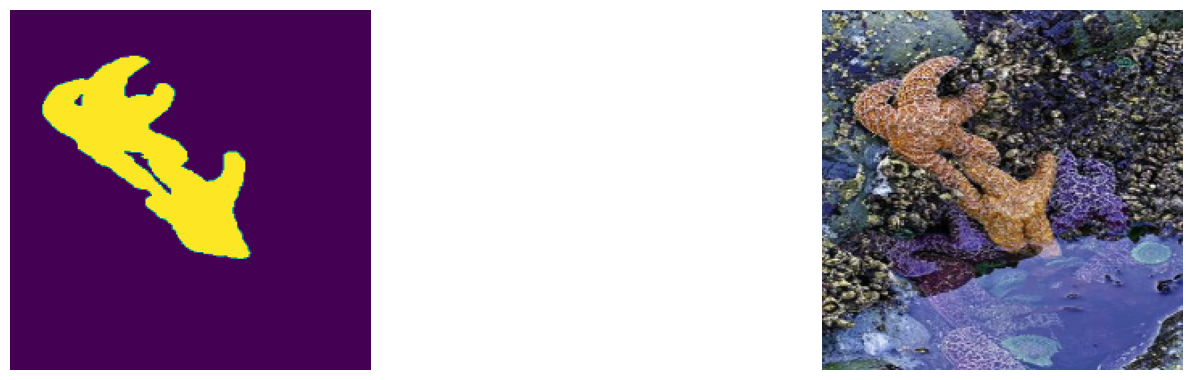

In [13]:
visualizeGenerator(val_gen)


Define The Model


In [14]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-_m1ntglh
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-_m1ntglh
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1694556533.224118390420868118806081040175592332373432988400-py3-none-any.whl size=301567 sha256=cd5837f9aff362da90b072b1152e7bc97c1c66f48a924920ee74392fc2ff8e08
  Stored in directory: /tmp/pip-ephem-wheel-cache-0pq9dbs9/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [15]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output



In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

In [18]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [19]:
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

    # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)


In [21]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [26]:
a = getImage(val_images[0].replace('.png', '.jpg'), f'{dataDir}/DUTS-TE/DUTS-TE-Image', (224,224))
m = getImage(val_images[0], f'{dataDir}/DUTS-TE/DUTS-TE-Mask', (224,224))
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    l = model.predict(tf.expand_dims(a, 0))
    l = create_mask(l)
    display_list = [a, m, l]
    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(display_list[i])
      plt.axis('off')
    plt.show()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 22ms/step


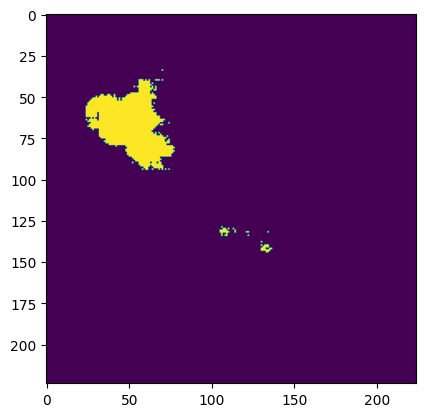

In [32]:
l = model.predict(tf.expand_dims(a, 0))
l = create_mask(l)
plt.imshow(l)

1/1 [==============================] - 0s 21ms/step


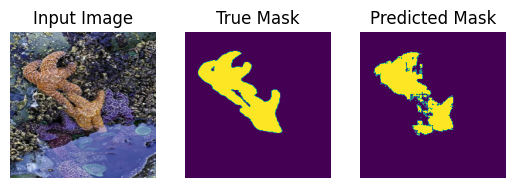


Sample Prediction after epoch 10

2638/2638 [==============================] - 183s 70ms/step - loss: 0.0975 - accuracy: 0.7504 - val_loss: 0.1574 - val_accuracy: 0.8778


In [37]:
# Set your parameters
n_epochs = 20

steps_per_epoch = len(train_images) // 4
validation_steps = len(val_images) // 4

# Start the training process
history = model.fit(x = train_gen,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                batch_size=4,
                callbacks=[DisplayCallback()],
                verbose = True)



In [40]:
model.save('DUTS_set_unet_semantic_segmentation_224_224_10_epochs.keras')

In [ ]:
a = getImage(val_images[0], './coco2017/images/val', (224,224))
plt.imshow(a)
m = getBinaryMask(val_images[0], val_coco, (224,224))
plt.imshow(m)

In [ ]:
l = model.predict(tf.expand_dims(a, 0))


In [ ]:
plt.imshow(create_mask(l))